# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style*

---

Some of the follow may be not necessary run, which will clearly defined in the comment above every code block.'# no need to run...'

When loading the trained model, you will need to initialize the model (the smae to training the model). Without initialization, it will raise an error. In the loading skip_gram_model and loading char_emb_model section, read carefully in the comments.

In the final sequence training section, instead of loading model, I implement loading dictionary that maps words and their word_embedding and char_embedding. In doing so, there is no need to initialize the model. If you want get the embedding dictionary by yourself, you need to run codes in loading models in the section 2.1.5. and 2.2.5. Hint: Don't forget to initialize model before you load it :)

***Visualising the comparison of different results is a good way to justify your decision.***

# 1 - Data Preprocessing

## 1.1. Download Dataset

In [3]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

import pandas as pd
df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

Training set number: 25000
Testing set number: 25000


## 1.2. Preprocess data

*You are required to describe which data preprocessing techniques were conducted with justification of your decision. *

In [44]:
# Please comment your code
# Import necessary modules if colab goes wrong ()
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder

import numpy as np
import json

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, classification_report

# if GPU is available, use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# check if GPU is enabled
print(torch.cuda.is_available())

True


In [0]:
def upload_file(file_name):
    '''
    Upload file into Google Drives and return the file id
    It will require Google Authentication
    Sorry that it will upload sereval files into your Google Drives
    '''
    uploaded = drive.CreateFile({'title': file_name})
    uploaded.SetContentFile(file_name)
    uploaded.Upload()
    id = uploaded.get('id')
    print('Uploaded file {} with ID {}'.format(file_name, id))

    return id

In [0]:
def get_embeddings(corpus, embeddings):
    '''
    find every word with its embeddings
    '''
    out = {}
    for word in corpus:
        out[word] = embeddings[word_dict[word]].tolist()
    return out

For the problem, I think there are five steps needed to implement for data preprocessing.

The first is decapitalization. Because the first letter is always capitalized. If the original text is used for a further model, the capitalized words are recognized as different from the capitalized words, which will increase the size of data set and also reduce the accuracy.

The second step is punctuation remove. There is very little even no real meaning from Punctuation, so better ignore them.

The third step is tokenization. I need to get a list of individual tokens from the comments.

The fourth step is to delete the stop words. Due to that stop words usually are not important to the main meaning of a sentence. Therefore, deleting stop words is a way to extract the core ideas or parts of a sentence.

The last step is lemmatisation. Implementing this to avoid unnecessary identification. 

For the sentiment labels, I coded these labels using unique numeric variable.

In [5]:
# Data preprocessing
# Decapitalization
reviews_train = [sentence.lower() for sentence in reviews_train]
reviews_test = [sentence.lower() for sentence in reviews_test]

# Remove punctuations
def remove_punctuation_re(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence

reviews_train = [remove_punctuation_re(sentence) for sentence in reviews_train]
reviews_test = [remove_punctuation_re(sentence) for sentence in reviews_test]

# Tokenization
reviews_train = [word_tokenize(sentence) for sentence in reviews_train]
reviews_test = [word_tokenize(sentence) for sentence in reviews_test]

# Remove stopwords
stop_words = sw.words()

reviews_train_ns = []
for tokens in reviews_train:
    sentence_ns = [token for token in tokens if not token in stop_words]
    reviews_train_ns.append(sentence_ns)

reviews_test_ns = []
for tokens in reviews_test:
    sentence_ns = [token for token in tokens if not token in stop_words]
    reviews_test_ns.append(sentence_ns)

# Lemmatisation
lemmatizer = WordNetLemmatizer()

reviews_train_lemma = []
for tokens in reviews_train_ns:
    sentence_lemma = [lemmatizer.lemmatize(token) for token in tokens]
    reviews_train_lemma.append(sentence_lemma)

reviews_test_lemma = []
for tokens in reviews_test_ns:
    sentence_lemma = [lemmatizer.lemmatize(token) for token in tokens]
    reviews_test_lemma.append(sentence_lemma)

# Label encoding
labels = np.unique(sentiments_train)
labelencoder = LabelEncoder()
labelencoder.fit(labels)
label_train = labelencoder.transform(sentiments_train)
label_test = labelencoder.transform(sentiments_test)
number_of_class = len(labels)

# save the clean data and delete duplicated varaiables to save space
reviews_train = reviews_train_lemma
reviews_test = reviews_test_lemma
del df_train, df_test, reviews_train_lemma, reviews_test_lemma, reviews_train_ns, reviews_test_ns, sentiments_train, sentiments_test

json.dump(reviews_train, open('reviews_train.json', 'w'))
id_reviews_train_json = upload_file('reviews_train.json')

json.dump(reviews_test, open('reviews_test.json', 'w'))
id_reviews_test_json = upload_file('reviews_test.json')

np.save('label_train.npy', label_train)
id_label_train_npy = upload_file('label_train.npy')

np.save('label_test.npy', label_test)
id_label_test_npy = upload_file('label_test.npy')

Uploaded file reviews_train.json with ID 1S8snJFWC_-V630cs33_QqVFgxxSecfiD
Uploaded file reviews_test.json with ID 1oWE-qSgaoXNiBE_Zrux24MzrDQgfuvDT
Uploaded file label_train.npy with ID 1R4FRauVU3mMBs8sjPsh2zfiLxgnXQ-i_
Uploaded file label_test.npy with ID 1TW_1r1Ihlk8B79qt4IbyqoUpl6pKcgXA


In [0]:
# Ignore this code section if you are marking this aasignment, 
# otherwiae it will updata files into your Google Drives
id_reviews_train_json = upload_file('reviews_train.json')
id_reviews_test_json = upload_file('reviews_test.json')
id_label_train_npy = upload_file('label_train.npy')
id_label_test_npy = upload_file('label_test.npy')

# 2 - Model Implementation

## 2.1. Word Embeddings

*You are required to describe which model was implemented (i.e. Word2Vec with CBOW, FastText with SkipGram, etc.) with justification of your decision *

In this section, The method implemented here is the SkipGram of Word2Vec using Pytorch. 

Firstly, although FastText method can train the model way more faster and process words that are not in the training vocabulary corpus, it will loss sequential information between words. In light of this, Word2Vec is chosen in this case.

Secondly, as we all know, CBOW is an algorithm to predict a word from giving context and also can find the most possible target word by inspectinging the context. However, it can have problems when dealing with rare words that did not appear frequently. For example here is the sentence: 'I think she is a ... girl.', the most poosible word here can be 'beatiful', while other words like 'cutey', 'seraphic' will be forgotten because they appears less frequently. Contrastly, Skip-gram model perform an opposing task, which is to predict context by a giving word. This require model to understand the giving word, including the meanings and relationship to other words. With this feature, our model can better under stand what the reviews are saying.

Finally, our data set is not very large, it has 25000 training data and 25000 test data. To find out the word frequency distribution (how many times one unique word appears in our data set), I plot two figures below. It can be seen that nearly 100,000 words only appear single time in our data set. Therefore, Skip-grams is more suitable in this case.



![](https://drive.google.com/uc?id=1HKuVTpfMvmv1p0I-FclUJ6EfQuEtbiXt) ![](https://drive.google.com/uc?id=13r64UUTDk6um3jh65IPN13aPj9FSMov0)

In [6]:
# Please comment your code
# create a dictionary with (key: value) is (unique word: times appears in data set) 
dictionary = {}
for sentence in reviews_train:
    for word in sentence:
        dictionary[word] = dictionary.get(word, 0) + 1
for sentence in reviews_test:
    for word in sentence:
        dictionary[word] = dictionary.get(word, 0) + 1
print('There are totally ' + str(len(dictionary)) + ' different words.')

There are totally 169284 different words.


[2401, 98964, 1636, 13055, 468, 218, 2291, 2853, 1421, 8040, 1244, 6656, 243, 6920, 233, 23591, 5716, 1, 113783, 4502, 283, 1, 79, 118, 6580, 19, 74, 65, 25, 1, 31, 233, 404, 1, 5, 1617, 1743, 350, 2, 2336, 342, 1882, 1069, 6, 593, 27601, 171, 10, 3, 4919, 2012, 2016, 6111, 8417, 255, 7048, 1, 1983, 3297, 421, 1748, 276, 47, 6542, 4257, 27, 5137, 50, 400, 235, 62, 6074, 24574, 2138, 448, 9981, 4457, 89745, 2721, 60, 1, 696, 9209, 29345, 22948, 1452, 802, 7302, 637, 39, 6984, 2304, 13404, 772, 207, 1819, 1064, 803, 4584, 4212, 13369, 2444, 7174, 10801, 8994, 17899, 2003, 15415, 4983, 37, 20, 224, 894, 927, 1569, 5473, 1736, 107, 2688, 12874, 618, 694, 2475, 12483, 1890, 31, 206, 1545, 9005, 684, 1598, 4892, 3636, 388, 679, 8, 241, 106, 219, 12330, 3392, 103, 86, 9722, 8817, 11050, 3444, 5981, 680, 359, 81, 1877, 734, 5734, 2578, 623, 470, 961, 1, 415, 99, 251, 147, 454, 373, 299, 142, 199, 1861, 13, 4727, 1462, 5050, 1149, 563, 1, 3202, 11622, 17705, 1306, 4683, 1269, 1988, 16947, 1641,

(array([1.69058e+05, 1.51000e+02, 2.90000e+01, 2.00000e+01, 1.10000e+01,
        1.00000e+00, 7.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 3.79373333e+03, 7.58646667e+03, 1.13792000e+04,
        1.51719333e+04, 1.89646667e+04, 2.27574000e+04, 2.65501333e+04,
        3.03428667e+04, 3.41356000e+04, 3.79283333e+04, 4.17210667e+04,
        4.55138000e+04, 4.93065333e+04, 5.30992667e+04, 5.68920000e+04,
        6.06847333e+04, 6.44774667e+04, 6.82702000e+04, 7.20629333e+04,
        7.58556667e+04, 7.96484000e+04, 8.34411333e+04, 8.72338667e+04,
        9.10266000e+04, 9.48193333e+04, 9.86120667e+04, 1.02404800e+05,
        1.06197533e+05, 1.09990267e+05, 1.13783000e+05])

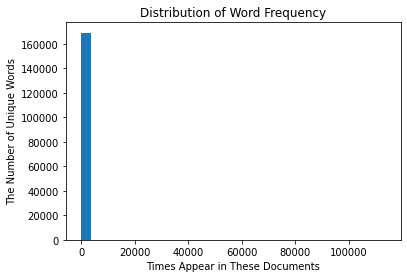

In [7]:
# plot word frequency distribution
# no need to run if you are marking this assignment

frequency = []
for key, value in dictionary.items():
    frequency.append(value)
print(frequency)

plt.xlabel('Times Appear in These Documents')
plt.ylabel('The Number of Unique Words')
plt.title('Distribution of Word Frequency')
plt.hist(frequency, bins = 30)

(array([96105., 18552.,  8863.,  5589.,  3962.,  2986.,  2425.,  2024.,
         1655.,  1419.,  1225.,  1093.,   957.,   853.,   799.,   725.,
          641.,   593.,   554.,   555.,   496.,   427.,   445.,   392.,
          376.,   360.,   349.,   313.,   287.,   272.]),
 array([ 1.        ,  1.96666667,  2.93333333,  3.9       ,  4.86666667,
         5.83333333,  6.8       ,  7.76666667,  8.73333333,  9.7       ,
        10.66666667, 11.63333333, 12.6       , 13.56666667, 14.53333333,
        15.5       , 16.46666667, 17.43333333, 18.4       , 19.36666667,
        20.33333333, 21.3       , 22.26666667, 23.23333333, 24.2       ,
        25.16666667, 26.13333333, 27.1       , 28.06666667, 29.03333333,
        30.        ]),
 <a list of 30 Patch objects>)

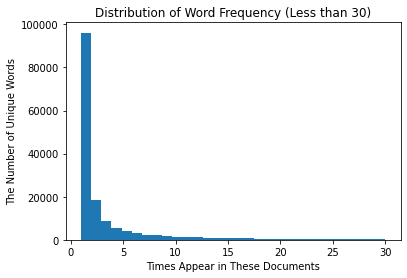

In [8]:
# plot word frequency distribution with frequency less than 30
# no need to run if you are marking this assignment

frequency_30 = []
for freq in frequency:
    if freq <= 30:
        frequency_30.append(freq)

plt.xlabel('Times Appear in These Documents')
plt.ylabel('The Number of Unique Words')
plt.title('Distribution of Word Frequency (Less than 30)')
plt.hist(frequency_30, bins = 30)

In [0]:
# delete unnecessary variables to save space
del frequency, frequency_30

### 2.1.1. Data Preprocessing for Word Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

**Important**: If you are going to use the code from lab3 word2vec preprocessing. Please note that `word_list = list(set(word_list)) ` has randomness. So to make sure the word_list is the same every time you run it, you can put `word_list.sort()` after that line of code.

In [10]:
# Remove less frequent words
reviews_train_no_less_freq = []
reviews_test_no_less_freq = []

for sentence in reviews_train:
    temp = []
    for word in sentence:
        if dictionary[word] >= 4:  # if the word appears more than 3 times, add it to our model
            temp.append(word)
    reviews_train_no_less_freq.append(temp)

for sentence in reviews_test:
    temp = []
    for word in sentence:
        if dictionary[word] >= 4:  # do the same thing to test data set
            temp.append(word)
    reviews_test_no_less_freq.append(temp)

# save these two preprocessed data set to current runtime
json.dump(reviews_train_no_less_freq, open('reviews_train_no_less_freq.json', 'w'))
json.dump(reviews_test_no_less_freq, open('reviews_test_no_less_freq.json', 'w'))


Uploaded file reviews_train_no_less_freq.json with ID 1D-zRo0kL9umQoxvwF0eRLOf2vtgkk0Sh
Uploaded file reviews_test_no_less_freq.json with ID 1eVt3JTh-7V4No1FVOtIvmInXF3iDVjJz


In [0]:
# save the preprocessed data set to Google Drives in case of colab collapse
# no need to run if you are marking this assignment
id_reviews_train_no_less_freq_json = upload_file('reviews_train_no_less_freq.json')
id_reviews_test_no_less_freq_json = upload_file('reviews_test_no_less_freq.json')

In [0]:
# delete unnecessary variables to save space
del reviews_train, reviews_test, dictionary

In [0]:
# download saved data set from Google Drives
# no need to run if these data sets already exist
id = '1D-zRo0kL9umQoxvwF0eRLOf2vtgkk0Sh'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('reviews_train_no_less_freq.json')

id = '1eVt3JTh-7V4No1FVOtIvmInXF3iDVjJz'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('reviews_test_no_less_freq.json')

reviews_train_no_less_freq = json.load(open('reviews_train_no_less_freq.json'))
reviews_test_no_less_freq = json.load(open('reviews_test_no_less_freq.json'))

In [0]:
# load preprocessed data set from current runtime
# no need to run if these data sets already exist
reviews_train_no_less_freq = json.load(open('reviews_train_no_less_freq.json'))
reviews_test_no_less_freq = json.load(open('reviews_test_no_less_freq.json'))

In [41]:
# Please comment your code
# Get the word sequence list
word_sequence = []

for sentence in reviews_train_no_less_freq:
    for word in sentence:
        word_sequence.append(word)

for sentence in reviews_test_no_less_freq:
    for word in sentence:
        word_sequence.append(word)

# Get a vocabulary list for the unique words
word_list = sorted(list(set(word_sequence)))
voc_size = len(word_list)
print('There are totally ' + str(voc_size) + ' different words.')

# Make dictionary maps between unique words and their index in word_list
word_dict = {word: index for index, word in enumerate(word_list)}

There are totally 45764 different words.


In [13]:
# Making window size 2 skip_gram
skip_grams = []

for i in range(2, len(word_sequence) - 2):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 2]], 
               word_dict[word_sequence[i - 1]], 
               word_dict[word_sequence[i + 1]], 
               word_dict[word_sequence[i + 2]]]
    for word in context:
        skip_grams.append([target, word])

# save these two files to current runtime
json.dump(word_list, open('word_list.json', 'w'))
json.dump(skip_grams, open('skip_grams.json', 'w'))

Uploaded file word_list.json with ID 1zUA-Z5GMhqy0bBGfIN3geQlRquel1cug


In [0]:
# delete unnecessary variables to save space
del word_sequence

In [0]:
# prepare random training batch for skip-gram model training
# the training data set is not large so we's better randomly select them
def prepare_batch(data, size):
    '''
    split the data set randomly based on giving batch size
    return the prepared input and target
    '''
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    
    for i in random_index:
        input_temp = [0] * voc_size
        input_temp[data[i][0]] = 1
        random_inputs.append(input_temp)                     # target
        random_labels.append(data[i][1])                     # context word
    return np.array(random_inputs), np.array(random_labels)

### 2.1.2. Build Word Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

Below is my hyperparameters expriments:

the batch_size is usually to be 2^n, if the batch size is too small, the learning can be unstable. On the other hand, if it is too large, it can take more time for training, so I chose 1024 here. The embedding_size here is 20 finally, because the CUDA can be out of memory if it is 50.

Firstly, I set word_learning_rate = 0.01,
batch_size = 1024,
embedding_size = 50,
word_epochs = 100.
Overall the performance is acceptable, however, big fluctuation can be seen in the last several epochs.

![](https://drive.google.com/uc?id=1IimEWEtx_6pOnTbycnW3Gj5Zl7JzA5bk)

Next, I tried with smaller learning rate and more epochs, but the result is not quite good enough. word_learning_rate = 6e-3,
batch_size = 1024,
embedding_size = 50,
word_epochs = 200.

![](https://drive.google.com/uc?id=18p5C48dVYStjQa-LZLoWiRPhtWcrUvdW)

Then, I tried more epochs with a little bigger learning rate, the fuctuation comes back, word_learning_rate = 5e-3,
batch_size = 512,
embedding_size = 50,
word_epochs = 300.

![](https://drive.google.com/uc?id=14VnchkzDFaDhmIgfRl5Beo_y4gH-7pqU)


This time, I tried to set embedding_size 20, and similar fluctuation in last several epochs. word_learning_rate = 6e-3,
batch_size = 512,
embedding_size = 20,
word_epochs = 300.

![](https://drive.google.com/uc?id=1fM87N3V2upsxDxBGHDsh6lkmVH8LLu92)

Finally, I tried even smaller learning rate with more epochs, the learning curve looks accepetable, so I decided use these hyperparemeters to train our model. word_learning_rate = 2e-3,
batch_size = 1024,
embedding_size = 20,
word_epochs = 500.


![](https://drive.google.com/uc?id=17JYQUU_xFK-nfyRxYi5O262elFg9LWYG)

In [0]:
# Please comment your code
# hyperparameters
word_learning_rate = 2e-3
batch_size = 1024
embedding_size = 20
word_epochs = 500

In [0]:
# build our Skip-Grams model
# please initialize this model before you load it
class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        self.linear1 = nn.Linear(voc_size, embedding_size, bias=False)
        self.linear2 = nn.Linear(embedding_size, voc_size, bias=False)

    def forward(self, x):
        hidden = self.linear1(x)
        out = self.linear2(hidden)
        return out

# convert to GPU mode if available
skip_gram_model = SkipGram().to(device)
criterion = nn.CrossEntropyLoss()  # please note we are using "CrossEntrop yLoss" here
optimiser = optim.Adam(skip_gram_model.parameters(), lr=word_learning_rate)

### 2.1.3. Train Word Embeddings Model

Epoch: 10, loss: 10.7309
Epoch: 20, loss: 10.7307
Epoch: 30, loss: 10.7290
Epoch: 40, loss: 10.7254
Epoch: 50, loss: 10.7152
Epoch: 60, loss: 10.6997
Epoch: 70, loss: 10.6682
Epoch: 80, loss: 10.6117
Epoch: 90, loss: 10.5468
Epoch: 100, loss: 10.4411
Epoch: 110, loss: 10.3754
Epoch: 120, loss: 10.2264
Epoch: 130, loss: 10.1409
Epoch: 140, loss: 9.8974
Epoch: 150, loss: 9.7704
Epoch: 160, loss: 9.6615
Epoch: 170, loss: 9.6083
Epoch: 180, loss: 9.3890
Epoch: 190, loss: 9.3070
Epoch: 200, loss: 9.2935
Epoch: 210, loss: 9.1470
Epoch: 220, loss: 9.1202
Epoch: 230, loss: 9.0051
Epoch: 240, loss: 9.0821
Epoch: 250, loss: 8.9227
Epoch: 260, loss: 8.9724
Epoch: 270, loss: 8.9352
Epoch: 280, loss: 8.7694
Epoch: 290, loss: 8.8589
Epoch: 300, loss: 8.8643
Epoch: 310, loss: 8.8593
Epoch: 320, loss: 8.7722
Epoch: 330, loss: 8.5588
Epoch: 340, loss: 8.6696
Epoch: 350, loss: 8.6795
Epoch: 360, loss: 8.6793
Epoch: 370, loss: 8.5954
Epoch: 380, loss: 8.5953
Epoch: 390, loss: 8.5683
Epoch: 400, loss: 8.6

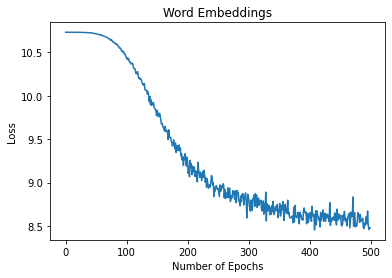

In [18]:
# while training, record the performance for choosing hyperparameters
epoch_num = []
loss_num = []
display_interval = 10

for epoch in range(word_epochs):
    inputs, embedding_labels = prepare_batch(skip_grams, batch_size)
    inputs_torch = torch.from_numpy(inputs).float().to(device)
    labels_torch = torch.from_numpy(embedding_labels).to(device)

    # 1. zero grad
    skip_gram_model.train()
    optimiser.zero_grad()

    # 2. forword propagation
    outputs = skip_gram_model(inputs_torch)
    
    # 3. calculate loss
    loss = criterion(outputs, labels_torch)
    
    # 4. back propagation
    loss.backward()
    optimiser.step()

    # dispaly loss every 10 epochs
    if epoch % display_interval == display_interval - 1:
        print('Epoch: %d, loss: %.4f' %(epoch + 1, loss))
    epoch_num.append(epoch)
    loss_num.append(loss)

# plot in figure
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Word Embeddings')
plt.plot(epoch_num, loss_num)
plt.show()

### 2.1.4. Save Word Embeddings Model

In [19]:
# Please comment your code
# save the trained skip-gram model to current runtime
torch.save(skip_gram_model, 'skip_gram_model.pt')

# upload the trained skip-gram model to Google Drives
id_skip_gram_model_pt = upload_file('skip_gram_model.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SkipGram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Uploaded file skip_gram_model.pt with ID 1Q4XBA9h7_6Q62uDTKioJO29bara0M3xE


In [0]:
# delete local variables to save space
del skip_gram_model

### 2.1.5. Load Word Embeddings Model

In [0]:
# download skip-gram model from Google Drives
# please initialize the model before loading it
id = '1Q4XBA9h7_6Q62uDTKioJO29bara0M3xE'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('word_emb_model.pt')

In [20]:
# Please comment your code
# please initialize the model before loading it
word_emb_model = torch.load('skip_gram_model.pt')
# set the flag to evaluation
word_emb_model.eval()

# Get word embedding list
weight1 = word_emb_model.linear1.weight
word_embeddings = weight1.detach().T.cpu().numpy()
print(word_embeddings.shape)


def get_embeddings(corpus, embeddings):
    '''
    find every word with its embeddings
    '''
    out = {}
    for word in corpus:
        out[word] = embeddings[word_dict[word]].tolist()
    return out

# for every word in word_list, find their embeddings
word_emb_dict = get_embeddings(word_list, word_embeddings)

np.save('word_embedding.npy', word_embeddings)
id_word_embedding_npy = upload_file('word_embedding.npy')

(45764, 20)
Uploaded file word_embedding.npy with ID 1PnngRPTbvYkR0e-SSAXH3630PX7OPIcB


In [0]:
# save files in current runtime
np.save('word_embedding.npy', word_embeddings)
json.dump(word_emb_dict, open('word_emb_dict.json', 'w'))

In [0]:
# upload files into Google Drives
# no need to run if you are marking this assignment
id_word_embedding_npy = upload_file('word_embedding.npy')
id_word_emb_dict_json = upload_file('word_emb_dict.json')

In [0]:
# saving space
del word_embeddings, weight1, word_emb_model

## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

I find out that over 99 percent of total words are shorter than 16, but the longest word can be more 70 (maybe some url or something), which can be meaningless, so it is better to remove them (with length more than 15), and padding shorter words to make them equal length.

![](https://drive.google.com/uc?id=18RestJ6bh8hgpYUklNE_1JxFUo6enoeH)

In [0]:
# load the word_list from current runtime
# no need to run if this variable already exists
word_list = json.load(open('word_list.json'))
word_emb_dict = json.load(open('word_emb_dict.json'))

The longest word has 72 characters.
Words with length less than 16 account to 0.9962415872738397 of total.


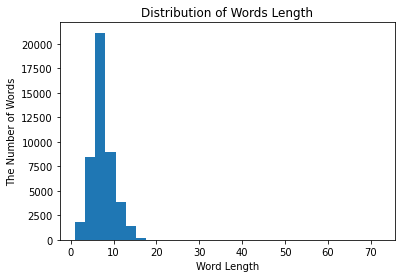

In [25]:
# Please comment your code
# to find out word length distribution
# no need to run if you are marking this assignment
word_len_list = [len(word) for word in word_list]
plt.xlabel('Word Length')
plt.ylabel('The Number of Words')
plt.title('Distribution of Words Length')
plt.hist(word_len_list, bins = 30)
print('The longest word has ' + str(max(word_len_list)) + ' characters.')
print('Words with length less than 16 account to ', end='')
print(len([length for length in word_len_list if length <= 15]) / len(word_len_list), end='')
print(' of total.')

In [0]:
# word padding
word_length = 15
char_list = []
word_list_pad = []

for word in word_list:
    # if the word length exceeds 15, cut it
    # else pad with '+'
    if len(word) > word_length:
        word_list_pad.append(word[: word_length])
    else:
        for j in range(word_length - len(word)):
            word += "+"
        word_list_pad.append(word)

# find every character exist in current data set
for word in word_list_pad:
    for char in word:
        char_list.append(char)

# unique character
char_arr = sorted(list(set(char_list)))

In [0]:
# store position of every character
char_dictionary = {char: index for index, char in enumerate(char_arr)}

# one-hot encoding and decoding
char_dictionary_len = len(char_dictionary)
onehot = np.eye(char_dictionary_len)

In [0]:
# Make a batch to have sequence data for input and ouput
def make_batch(seq_data):
    input_batch = []
    target_batch = []
    
    for word in seq_data:
        # input is the position of every character of the word
        input_data = [char_dictionary[char] for char in word]
        # target the word embedding
        target = word_emb_dict[word_list[seq_data.index(word)]]
        input_batch.append(onehot[input_data])
        target_batch.append(target)
    
    return input_batch, target_batch

### 2.2.2. Build Character Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

Below is my hyperparameters experiments:

char_learning_rate = 0.1, 
n_hidden = 25, 
char_epochs = 60, 
 Number of sequences for RNN, 
n_step = 3, 
 number of inputs (dimension of input vector), 
n_input = char_dictionary_len, 
 number of classes, 
n_class = 50, during the first attempt, my word_embedding_size is 50 so it is 50 here. However, the learning curve looks not good.

![](https://drive.google.com/uc?id=1Rjl-pz3fplsggCeqryHgfWR7xtSIPS3y)

So, I tried smaller learning rate and more epoch, but the result is not good enough. char_learning_rate = 1e-2, 
n_hidden = 10, 
char_epochs = 150, 
n_step = 3, 
n_input = char_dictionary_len, 
n_class = 20,

![](https://drive.google.com/uc?id=1Z-3KeL_I1Nqf1cDJRURuSBxr7byq2o7F)

This time, a little bigger learning rate is chosen, now it looks acceptable. char_learning_rate = 4e-2
n_hidden = 10
char_epochs = 170
n_step = 3
n_input = char_dictionary_len
n_class = 20

![](https://drive.google.com/uc?id=1H40_zQ7jQxGP9IKFSDHiv5SXVV86oDue)

In [0]:
# Please comment your code
# Hyperparameters
char_learning_rate = 4e-2
n_hidden = 10
char_epochs = 170
# Number of sequences for RNN
n_step = 3
# number of inputs (dimension of input vector)
n_input = char_dictionary_len
# number of classes
n_class = 20

In [25]:
# build the biLETM model
# please initialize this model before you load it
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True, bidirectional=True, dropout=0.2)
        self.linear = nn.Linear(n_hidden*2, n_class)
    
    def forward(self, sentence):
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n, c_n) = self.lstm(sentence)
        #concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0, :, :], h_n[1, :, :]), 1)
        z = self.linear(hidden_out)
        return z, hidden_out


# Move the model to GPU
net = Net().to(device)
# Loss function and optimizer
char_criterion = nn.MSELoss()
chat_optimizer = optim.Adam(net.parameters(), lr=char_learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
# Preparing input
char_input_batch, char_target_batch = make_batch(word_list_pad)

# Convert input into tensors and move them to GPU by using tensor.to(device)
char_input_batch_torch = torch.from_numpy(np.array(char_input_batch)).float().to(device)
char_target_batch_torch = torch.from_numpy(np.array(char_target_batch)).to(device)
char_target_batch_torch = char_target_batch_torch.type(torch.DoubleTensor)

# save data in current runtime
torch.save(char_input_batch_torch, 'char_input_batch_torch.pt')
torch.save(char_target_batch_torch, 'char_target_batch_torch.pt')

In [0]:
# upload files into Google Drives
# no need to run if you are marking this assignment
id_char_input_batch_torch_pt = upload_file('char_input_batch_torch.pt')
id_char_target_batch_torch_pt = upload_file('char_target_batch_torch.pt')

In [0]:
# saving space
del word_list_pad, char_input_batch, char_target_batch

### 2.2.3. Train Character Embeddings Model

In [0]:
# load the data 
# no need to run if these variable already exists
char_input_batch_torch = torch.load('char_input_batch_torch.pt')
char_target_batch_torch = torch.load('char_target_batch_torch.pt')

Epoch: 10, loss: 0.00489
Epoch: 20, loss: 0.00458
Epoch: 30, loss: 0.00450
Epoch: 40, loss: 0.00445
Epoch: 50, loss: 0.00442
Epoch: 60, loss: 0.00438
Epoch: 70, loss: 0.00434
Epoch: 80, loss: 0.00428
Epoch: 90, loss: 0.00425
Epoch: 100, loss: 0.00423
Epoch: 110, loss: 0.00422
Epoch: 120, loss: 0.00422
Epoch: 130, loss: 0.00421
Epoch: 140, loss: 0.00421
Epoch: 150, loss: 0.00420
Epoch: 160, loss: 0.00419
Epoch: 170, loss: 0.00418


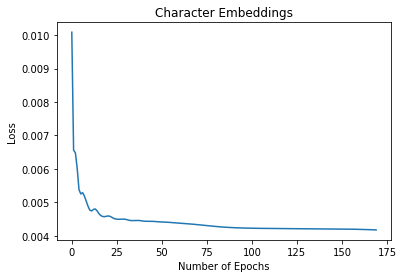

In [27]:
# Please comment your code
# record performance
epoch_num = []
loss_num = []
display_interval = 10

for epoch in range(char_epochs):
    # Set the flag to training
    net.train()
    # forward + backward + optimize
    outputs, _ = net(char_input_batch_torch)
    outputs = outputs.type(torch.DoubleTensor)
    loss = char_criterion(outputs, char_target_batch_torch)
    loss.backward()
    chat_optimizer.step()
    chat_optimizer.zero_grad()

    # Set the flag to evaluation, which will 'turn off' the dropout
    net.eval()
    outputs, _ = net(char_input_batch_torch)

    # Evaluation loss and accuracy calculation
    loss = char_criterion(outputs, char_target_batch_torch.cuda())
    _, predicted = torch.max(outputs, 1)

    # display loss every 10 epochs
    if epoch % display_interval == display_interval - 1:
        print('Epoch: %d, loss: %.5f' %(epoch + 1, loss.item()))
    epoch_num.append(epoch)
    loss_num.append(loss)

# plot the loss figure
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Character Embeddings')
plt.plot(epoch_num, loss_num)
plt.show()

In [0]:
# saving space
del char_target_batch_torch

### 2.2.4. Save Character Embeddings Model

In [33]:
# Please comment your code
# save the model in current runtime
torch.save(net, 'char_emb_model.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Uploaded file char_emb_model.pt with ID 1AyH8zholsmzkxoZUnEdOsrvXCVNstFIP


In [0]:
# upload files into Google Drives
# no need to run if you are marking this assignment
id_char_emb_model_pt = upload_file('char_emb_model.pt')

In [0]:
# saving space
del net

### 2.2.5. Load Character Embeddings Model

In [0]:
# download char embedding model from Google Drives
# please initialize the model before loading it
id = '1AyH8zholsmzkxoZUnEdOsrvXCVNstFIP'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('char_emb_model.pt')

char_emb_model = torch.load('char_emb_model.pt')
# set the flag to evaluation
char_emb_model.eval()

# Get character embedding list
_, hidden_state = char_emb_model(char_input_batch_torch)
char_embeddings = hidden_state.detach().cpu().numpy()
print(char_embeddings.shape)
# save the character embeddings
np.save('char_embedding.npy', char_embeddings)

# map every word with its char embeddings
char_emb_dict = get_embeddings(word_list, char_embeddings)
# save the mapping to current runtime
json.dump(char_emb_dict, open('char_emb_dict.json', 'w'))

In [0]:
# upload files into Google Drives
# no need to run if you are marking this assignment
id_char_emb_dict_json = upload_file('char_emb_dict.json')

In [0]:
# saving space
del char_embeddings, char_input_batch_torch, char_emb_model, hidden_state

## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [0]:
# load trained word_embedding dictionary from my Google Drives
id = '1TkA_JjEafRNTX0C9n9FuqN3i1rDQQVU7'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('word_emb_dict.json')

# load trained char_embedding dictionary from my Google Drives
id = '1ORBNkccM8tnuO0UC_qfMYpVpWRFjWKZD'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('char_emb_dict.json')

# load processed training data set
id = '1D-zRo0kL9umQoxvwF0eRLOf2vtgkk0Sh'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('reviews_train_no_less_freq.json')

# load processed testing data set
id = '1eVt3JTh-7V4No1FVOtIvmInXF3iDVjJz'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('reviews_test_no_less_freq.json')

# load processed training label
id = '1R4FRauVU3mMBs8sjPsh2zfiLxgnXQ-i_'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('label_train.npy')

# load processed testing label
id = '1TW_1r1Ihlk8B79qt4IbyqoUpl6pKcgXA'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('label_test.npy')

word_emb_dict = json.load(open("word_emb_dict.json"))
char_emb_dict = json.load(open("char_emb_dict.json"))
reviews_train_no_less_freq = json.load(open("reviews_train_no_less_freq.json"))
reviews_test_no_less_freq = json.load(open("reviews_test_no_less_freq.json"))

label_train = np.load('label_train.npy')
label_test = np.load('label_test.npy')

Similar to word and chracter embedding, I need to inspect the sequence length distribution. In the figure below, the sentences with length under 300 take almost 95 percent of total data. In light of this, I pad all sentence to length 300.

![](https://drive.google.com/uc?id=1IXGX4fLeWyd_np23GZ-Bt7-dv1o6egFm)

Sentences with length less than 300 account to 0.94856 of total.


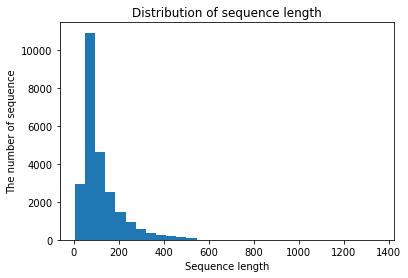

In [49]:
# this code block is to find out the sequence length distribution
# no need to run if you are marking this assignment
sequence_length_list = [len(sentence) for sentence in reviews_train_no_less_freq]
plt.xlabel('Sequence length')
plt.ylabel('The number of sequence')
plt.title('Distribution of sequence length')
plt.hist(sequence_length_list, bins=30)
print('Sentences with length less than 300 account to ', end='')
print(len([length for length in sequence_length_list if length <= 300]) / len(sequence_length_list), end='')
print(' of total.')

In [0]:
# Sequence Padding
sequence_length = 300  # target length


def add_padding(corpus, sequence_length):
    '''
    for sentence: if length > 300, cut it
    else: pad with '<PAD>'
    '''
    output = []
    for sentence in corpus:
        if len(sentence) > sequence_length:
            output.append(sentence[: sequence_length])
        else:
            for j in range(sequence_length - len(sentence)):
                sentence.append('<PAD>')
            output.append(sentence)
    return output


# implement sequence padding to train and test data set
reviews_train_pad = add_padding(reviews_train_no_less_freq, sequence_length)
reviews_test_pad = add_padding(reviews_test_no_less_freq, sequence_length)

# saving space
del reviews_train_no_less_freq, reviews_test_no_less_freq

In [0]:
# Please comment your code

embedding_size = 20  # based on previous experiments

# Add embeddings for '<PAD>'
word_emb_dict['<PAD>'] = [0] * embedding_size
char_emb_dict['<PAD>'] = [0] * embedding_size


# Get embeddings
def get_seq_embeddings(corpus, word_emb_dict, char_emb_dict):
    '''
    for every word in corpus, concate its word_embeddings and char_embeddings
    '''
    output = []
    for sentence in corpus:
        output_temp = []
        for word in sentence:
            output_temp.append(word_emb_dict[word] + char_emb_dict[word])
        output.append(output_temp)
    return np.array(output)


# Generate embeddings for training data set
train_seq_emb = get_seq_embeddings(reviews_train_pad, word_emb_dict, char_emb_dict)

# Generate embeddings for testing data set
test_seq_emb = get_seq_embeddings(reviews_test_pad, word_emb_dict, char_emb_dict)

# saving sequence embeddings
np.save('train_seq_emb.npy', train_seq_emb)
np.save('test_seq_emb.npy', test_seq_emb)

# saving space
del reviews_train_pad, reviews_test_pad, word_emb_dict, char_emb_dict

In [0]:
# no need to run if these variables already exist
train_seq_emb = np.load('train_seq_emb.npy')
test_seq_emb = np.load('test_seq_emb.npy')

### 2.3.2. Build Sequence Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [0]:
# Please comment your code
# prepare random batch
def prepare_batch(data, label, size):
    '''
    perform batch gereration for both training and testing data set
    '''
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i])                        # target
        random_labels.append(label[i])                       # context word
    
    return np.array(random_inputs), np.array(random_labels)

First time, my hyperparameters are 
n_input = 100, 
n_hidden = 16, 
n_class = 2, 
seq_epochs = 1000, 
seq_learning_rate = 5e-3, 
seq_batch_size = 256, and these may easily result in CUDA out of memory so I reduce the embedding_size to 20, so the number of input = 2 * 20 = 40. The result is strongly fluctuate during the training so decrease the learning rate in next attempt.

![](https://drive.google.com/uc?id=11WLUVSoZjraR9P9aPYOwu2kazVcQKisX)

This time, the curve looks that it is learning something from the data, however, it is stil not stable. n_input = 40, 
n_hidden = 32, 
n_class = 2, 
seq_epochs = 600, 
seq_learning_rate = 5e-5, 
seq_batch_size = 2048, 

![](https://drive.google.com/uc?id=18yGg9SDebN7P_iXdsY9UJbuwyqt8bBBL)

This time, I tried a different direction, but the result is not acceptable. n_input = 40, 
n_hidden = 64, 
n_class = 2, 
seq_epochs = 3000, 
seq_learning_rate = 5e-2, 
seq_batch_size = 2048, 

![](https://drive.google.com/uc?id=1jek_Ygtye7dLxjYgmvYz-75lYtIPkPGg)

this time I tried smaller batch size to accelerate learning, still fluctuate. 
n_input = 40, 
n_hidden = 32, 
n_class = 2,
seq_epochs = 3000,
seq_learning_rate = 8e-2,
seq_batch_size = 1024,

![](https://drive.google.com/uc?id=1VBvq6UUfmty9arcXmqph5qKBF-hKhuPX)
![](https://drive.google.com/uc?id=1_ozyZPjcyGCmO14TvIyAcaw8yWJ3ku6z)


Finally, with smaller learning rate and more epoch, the curve looks acceptable. n_input = 40,
n_hidden = 32,
n_class = 2,
seq_epochs = 4000,
seq_learning_rate = 8e-3,
seq_batch_size = 1024,

![](https://drive.google.com/uc?id=1A61vrEDLUk9JRkWEt8Ab0z7uf7szDeVw)
![](https://drive.google.com/uc?id=1DCe38I2ut8VfpYfpU-MRULcupo_DNgx3)

In [0]:
# Hyperparameters
n_input = 40
n_hidden = 32
n_class = 2
seq_epochs = 2900
seq_learning_rate = 8e-3
seq_batch_size = 1024

In [0]:
# build sequence model
# please initialize this model before you load it
class SeqNet(nn.Module):
    def __init__(self):
        super(SeqNet, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers=2, batch_first =True, bidirectional=True, dropout=0.2)
        self.linear = nn.Linear(n_hidden*2, n_class)
    
    def forward(self, sentence):
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        #concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        log_output = F.log_softmax(z, dim=1)
        return log_output, hidden_out


# move the model to GPU
seq_model = SeqNet().to(device)
# using negative log loss function
seq_criterion = nn.NLLLoss()
seq_optimizer = optim.Adam(seq_model.parameters(), lr=seq_learning_rate)

### 2.3.3. Train Sequence Model

Epoch:  100, train_loss: 0.69297, train_acc: 0.5283, test_loss: 0.68933, test_acc: 0.54444, f1: 0.50468
Epoch:  200, train_loss: 0.69073, train_acc: 0.5078, test_loss: 0.69074, test_acc: 0.52508, f1: 0.43097
Epoch:  300, train_loss: 0.67880, train_acc: 0.5654, test_loss: 0.67982, test_acc: 0.56608, f1: 0.55488
Epoch:  400, train_loss: 0.66880, train_acc: 0.6006, test_loss: 0.67895, test_acc: 0.57164, f1: 0.56480
Epoch:  500, train_loss: 0.67867, train_acc: 0.5791, test_loss: 0.67571, test_acc: 0.57592, f1: 0.57297
Epoch:  600, train_loss: 0.67332, train_acc: 0.6045, test_loss: 0.67167, test_acc: 0.58420, f1: 0.58420
Epoch:  700, train_loss: 0.66794, train_acc: 0.5713, test_loss: 0.67310, test_acc: 0.58584, f1: 0.57725
Epoch:  800, train_loss: 0.66052, train_acc: 0.6006, test_loss: 0.66458, test_acc: 0.59464, f1: 0.59220
Epoch:  900, train_loss: 0.65168, train_acc: 0.6230, test_loss: 0.66082, test_acc: 0.59948, f1: 0.59942
Epoch: 1000, train_loss: 0.65728, train_acc: 0.5967, test_loss: 

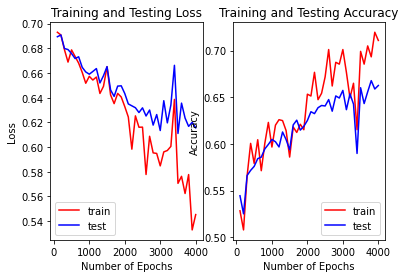

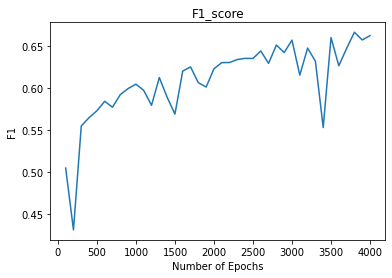

In [49]:
# Please comment your code
# record the performance
epoch_num = []
train_loss = []
test_loss = []
train_acc = []
test_acc = []
f1_value_list = []

for epoch in range(seq_epochs):
    # prepare batched data and move to GPU
    train_input_batch_torch, train_target_batch_torch = prepare_batch(train_seq_emb, label_train, seq_batch_size)
    train_input_batch_torch = torch.from_numpy(train_input_batch_torch).float().to(device)
    train_target_batch_torch = torch.from_numpy(train_target_batch_torch).view(-1).to(device)

    # set the flag to training
    seq_model.train()
    
    # forward + backward + optimize
    outputs, _ = seq_model(train_input_batch_torch)
    loss = seq_criterion(outputs, train_target_batch_torch)
    loss.backward()
    seq_optimizer.step()
    seq_optimizer.zero_grad()

    # evaluate performance every 100 epochs
    if epoch % 100 == 99:
        # set the flag to evaluation
        seq_model.eval()

        # forward to get output on train set
        outputs, _ = seq_model(train_input_batch_torch)

        # calculate loss on current train batch
        loss = seq_criterion(outputs, train_target_batch_torch)

        # record the training loss
        epoch_num.append(epoch)
        train_loss.append(loss.item())

        # convert outputs to predictions like (0,0,1,0,...,0,0)
        _, predicted = torch.max(outputs, 1)

        # calculate the prediction accuracy on train batch and record it
        train_accuracy = accuracy_score(predicted.cpu().numpy(), train_target_batch_torch.cpu().numpy())
        train_acc.append(train_accuracy)

        #prepare test batch
        test_input_batch_torch = torch.from_numpy(test_seq_emb).float().to(device)
        test_target_batch_torch = torch.from_numpy(label_test).view(-1).to(device)
        
        test_loss_epoch = []
        predictions = torch.empty(25000)
        # test the whole test set will explode CUDA memory, so I split the test set into 10 small batch
        for batch_num in range(10):
            # prepare current test batch
            temp_test_input_batch_torch = test_input_batch_torch[2500 * batch_num: 2500 * (batch_num + 1)]
            temp_test_target_batch_torch = test_target_batch_torch[2500 * batch_num: 2500 * (batch_num + 1)]

            # forward to get output on test batch
            outputs, _ = seq_model(temp_test_input_batch_torch)

            # calculate loss and record
            test_loss_batch = seq_criterion(outputs, temp_test_target_batch_torch)
            test_loss_epoch.append(test_loss_batch.detach().cpu().numpy())

            # get predictions on test set
            _, predicted = torch.max(outputs, 1)
            predictions[2500 * batch_num: 2500 * (batch_num + 1)] = predicted
        
        # find average loss of these batch and record it
        test_loss_epoch_average = np.mean(test_loss_epoch)
        test_loss.append(test_loss_epoch_average)

        # calculate the prediction accuracy on test set and record it
        test_accuracy = accuracy_score(predictions.cpu().numpy(), test_target_batch_torch.cpu().numpy())
        test_acc.append(test_accuracy)

        # record current f1 value
        f1_value = f1_score(test_target_batch_torch.cpu().numpy(), predictions.cpu().numpy(), average='weighted')
        f1_value_list.append(f1_value)

        print('Epoch: %4d, train_loss: %.5f, train_acc: %.4f, test_loss: %.5f, test_acc: %.5f, f1: %.5f' 
              %(epoch + 1, loss.item(), train_accuracy, test_loss_epoch_average, test_accuracy, f1_value))

print('Finished Training')

# plt figure
plt.figure()

plt.subplot(121)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.plot(epoch_num, train_loss, color='red', label='train')
plt.plot(epoch_num, test_loss, color='blue', label='test')
plt.legend(loc='lower left')

plt.subplot(122)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.plot(epoch_num, train_acc, color='red', label='train')
plt.plot(epoch_num, test_acc, color='blue', label='test')
plt.legend(loc='lower right')

plt.show()

plt.xlabel('Number of Epochs')
plt.ylabel('F1')
plt.title('F1_score')
plt.plot(epoch_num, f1_value_list)
plt.show()

### 2.3.4. Save Sequence Model

In [28]:
# Please comment your code
# save the model in current runtime
torch.save(seq_model, 'seq_model.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SeqNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [29]:
# upload files into Google Drives
# no need to run if you are marking this assignment
id_seq_model_pt = upload_file('seq_model.pt')

Uploaded file seq_model.pt with ID 1eDhR0AnZ3SNU343iYIhM0jUmamssZOop


In [0]:
# saving space
del seq_model

### 2.3.5. Load Sequence Model

In [0]:
# Please comment your code
# please initialize the model before loading it
# load the sequence model from Google Drives or current runtime
try:
    id = '1eDhR0AnZ3SNU343iYIhM0jUmamssZOop'
    downloaded = drive.CreateFile({'id': id})
    downloaded.GetContentFile('seq_model.pt')
    seq_model = torch.load('seq_model.pt')
except:
    seq_model = torch.load('seq_model.pt')

# 3 - Evaluation

(*Please show your empirical evidence*)

## 3.1. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.

In [51]:
# Please comment your code

#prepare testing data and move to GPU
test_input_torch = torch.from_numpy(test_seq_emb).float().to(device)
test_target_torch = torch.from_numpy(label_test).view(-1).to(device)

# set the flag to evaluation
seq_model.eval()
predictions = torch.empty(25000)

# forward every 2500 test data one time in case of exploding CUDA
for batch_num in range(10):
    # forward to get outputs
    outputs, _ = seq_model(test_input_torch[2500 * batch_num: 2500 * (batch_num + 1)])
    
    # get predictions
    _, predicted = torch.max(outputs, 1)
    predictions[2500 * batch_num: 2500 * (batch_num + 1)] = predicted

# print claasification report
from sklearn.metrics import classification_report
print(classification_report(test_target_torch.cpu().numpy(), predictions.cpu().numpy(), digits=4))

              precision    recall  f1-score   support

           0     0.7016    0.6942    0.6979     12500
           1     0.6974    0.7047    0.7010     12500

    accuracy                         0.6995     25000
   macro avg     0.6995    0.6995    0.6995     25000
weighted avg     0.6995    0.6995    0.6995     25000



## 3.2. Hyperparameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.*

In this case, my best epoch number can be 2900. Based on graph generated by the following code, it can be argued that the sequence model reached the best performance aroud the 2,900th epoch. Its f1_sore can reach nearly 70 percent, and after that clear evidence of overfitting can be noticed from the loss and accuracy figure, where the testing performance stop improve meanwhile the training performance continue becomes better.

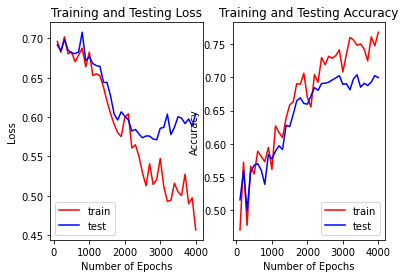

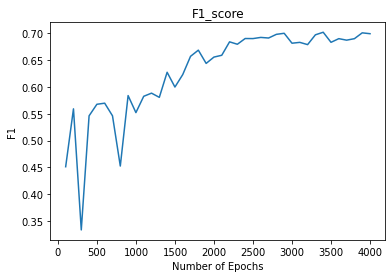

In [31]:
# Please comment your code
# Hyperparameters
n_input = 40
n_hidden = 32
n_class = 2
seq_epochs = 4000
seq_learning_rate = 8e-3
seq_batch_size = 1024

plt.figure()

plt.subplot(121)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.plot(epoch_num, train_loss, color='red', label='train')
plt.plot(epoch_num, test_loss, color='blue', label='test')
plt.legend(loc='lower left')

plt.subplot(122)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.plot(epoch_num, train_acc, color='red', label='train')
plt.plot(epoch_num, test_acc, color='blue', label='test')
plt.legend(loc='lower right')

plt.show()

plt.xlabel('Number of Epochs')
plt.ylabel('F1')
plt.title('F1_score')
plt.plot(epoch_num, f1_value_list)
plt.show()

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [0]:
# If you used OOP style, use this section